In [10]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import cartopy
import cartopy.crs as ccrs
import pandas as pd
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

In [91]:
case = "fanv3_2th"
path = "/glade/scratch/jinmuluo/archive/" + case + "/lnd/hist/" 
h = 'h0'
start_date = date(2000, 1, 1)
end_date = date(2000, 6, 1)
delta = end_date - start_date
fieldsh2 = ["N2O_DENITRIFY_TOTAL", "N2O_NITRIFY_TOTAL", "NOx_DENITRIFY_TOTAL", "NOx_NITRIFY_TOTAL", "area"]
fieldsh1 = ["NITRITE_G1", "NITRITE_G2", "NITRITE_G3", "NITRITE_S0", "NITRITE_S1", "NITRITE_S2",
            "NITRITE_S3", "NITRITE_F1", "NITRITE_F2",  "NITRITE_F3",  "NITRITE_F4",'area']
fieldsh0 = ["MANURE_NITRITE_RUNOFF", 'FERT_NITRITE_RUNOFF', "FERT_NITRITE_TO_SOIL", "MANURE_NITRITE_TO_SOIL", 'area']
fanCLM = []
for i in range(delta.days//30 + 1):
    month = start_date + relativedelta(months=i)
    month = month.strftime('%Y-%m')
    fanCLM.append(path + case + ".clm2." + h + "." + month +".nc")
print(len(fanCLM), fanCLM[-1])

6 /glade/scratch/jinmuluo/archive/fanv3_2th/lnd/hist/fanv3_2th.clm2.h0.2000-06.nc


In [92]:
def choose_field(h):
    if h == "h0":
        result = fieldsh0
    elif h == "h1":
        result = fieldsh1
    elif h == "h2":
        result = fieldsh2
    else:
        exit("please check your hist name!")
    return result

def preprocess(ds, fields = choose_field(h)):
    return(ds[fields])

def fix_time(ds):  
    date0 = ds['time'][0].values
    date1 = ds['time'][-1].values
    # ds['time'] =xr.cftime_range(str(yr0),periods=ndays,freq='D')
    ds['time'] = pd.date_range(str(date0),str(date1),freq='MS') 
    
    return ds

dsCLM = fix_time(xr.open_mfdataset(fanCLM, decode_times=True, preprocess=preprocess))
dsCLM

<xarray.Dataset>
Dimensions:                 (lat: 96, lon: 144, time: 6)
Coordinates:
  * time                    (time) datetime64[ns] 2000-02-01 ... 2000-07-01
  * lon                     (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * lat                     (lat) float32 -90.0 -88.11 -86.21 ... 88.11 90.0
Data variables:
    MANURE_NITRITE_RUNOFF   (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    FERT_NITRITE_RUNOFF     (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    FERT_NITRITE_TO_SOIL    (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    MANURE_NITRITE_TO_SOIL  (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    area                    (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
Attributes:
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 01/22/23 13:08:52
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    username:                             jinmuluo
    version:                              unknown
    revision_id:                          $Id: histFileMod.F90 42903 2012-12-...
    case_title:                           fanv3_2th
    case_id:                              fanv3_2th
    Surface_dataset:                      surfdata_1.9x2.5_hist_78pfts_CMIP6_...
    Initial_conditions_dataset:           finidat_interp_dest.nc
    PFT_physiological_constants_dataset:  clm50_params.c211112.nc
    ltype_vegetated_or_bare_soil:         1
    ltype_crop:                           2
    ltype_UNUSED:                         3
    ltype_landice:                        4
    ltype_deep_lake:                      5
    ltype_wetland:                        6
    ltype_urban_tbd:                      7
    ltype_urban_hd:                       8
    ltype_urban_md:                       9
    ctype_vegetated_or_bare_soil:         1
    ctype_crop:                           2
    ctype_crop_noncompete:                2*100+m, m=cft_lb,cft_ub
    ctype_landice:                        4*100+m, m=1,glcnec
    ctype_deep_lake:                      5
    ctype_wetland:                        6
    ctype_urban_roof:                     71
    ctype_urban_sunwall:                  72
    ctype_urban_shadewall:                73
    ctype_urban_impervious_road:          74
    ctype_urban_pervious_road:            75
    cft_c3_crop:                          1
    cft_c3_irrigated:                     2
    cft_temperate_corn:                   3
    cft_irrigated_temperate_corn:         4
    cft_spring_wheat:                     5
    cft_irrigated_spring_wheat:           6
    cft_winter_wheat:                     7
    cft_irrigated_winter_wheat:           8
    cft_temperate_soybean:                9
    cft_irrigated_temperate_soybean:      10
    cft_barley:                           11
    cft_irrigated_barley:                 12
    cft_winter_barley:                    13
    cft_irrigated_winter_barley:          14
    cft_rye:                              15
    cft_irrigated_rye:                    16
    cft_winter_rye:                       17
    cft_irrigated_winter_rye:             18
    cft_cassava:                          19
    cft_irrigated_cassava:                20
    cft_citrus:                           21
    cft_irrigated_citrus:                 22
    cft_cocoa:                            23
    cft_irrigated_cocoa:                  24
    cft_coffee:                           25
    cft_irrigated_coffee:                 26
    cft_cotton:                           27
    cft_irrigated_cotton:                 28
    cft_datepalm:                         29
    cf

In [86]:
def sp_plot(ds, field, coords, show=False):
    sp = ds.sel(lat=coords[0], lon=coords[1], method='nearest')
    if show:
        sp[field].plot(x='time')
        plt.show()
    return sp

In [87]:
def tot_plot(ds, field, show=False):
    # calculate global total emission (kgN/day)
    total = ds[field] * ds['area']
    total.attrs['units'] = 'TonN/s'
    total = total.sum(dim=['lat', 'lon'])
    if show:
        total.plot(x='time')
        plt.show()
    return total

In [88]:
def regional_plot(ds, field, coords, show=False):
    x = slice(coords['lower_lat'], coords['upper_lat'])
    y = slice(coords['west_lon'], coords['east_lon'])
    # gN/m2/s to TonN/s
    rp = (ds[field].sel(lat=x, lon=y) * ds['area'].sel(lat=x, lon=y)).sum(dim=['lat', 'lon'])
    if show:
        rp.plot(x='time')
        plt.show()
    return rp

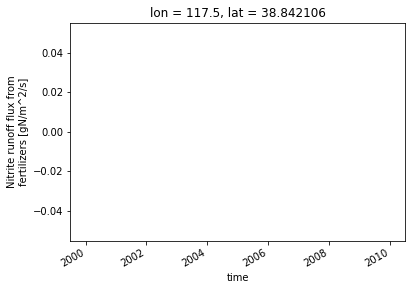

In [93]:
coordinates = [39.24, 116.25]
sp = sp_plot(ds=dsCLM, field=choose_field(h)[1], coords=coordinates, show=True)

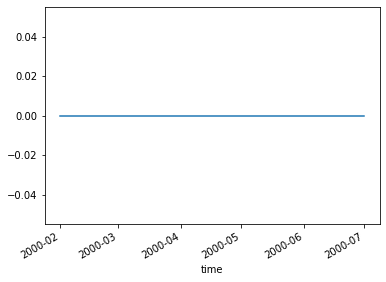

<xarray.DataArray (time: 6)>
dask.array<sum-aggregate, shape=(6,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-02-01 2000-03-01 ... 2000-07-01

In [95]:
tot_plot(ds=dsCLM, field=choose_field(h)[3], show=True)


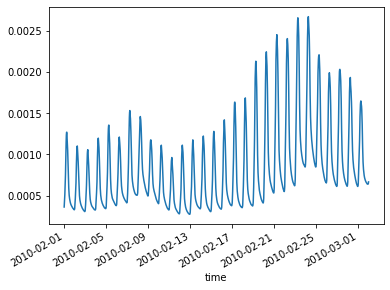

<xarray.DataArray (time: 1392)>
dask.array<sum-aggregate, shape=(1392,), dtype=float32, chunksize=(48,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2010-02-01 ... 2010-03-01T23:30:00

In [53]:
coordinates = {'upper_lat':45.50, 'lower_lat':25.35, 'west_lon': 100.00, 'east_lon':130.00}
regional_plot(ds=dsCLM, field=choose_field(h)[1], coords=coordinates, show=True)